In [302]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.linalg as la

from data import *
from models import train

# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


# Data generation functions

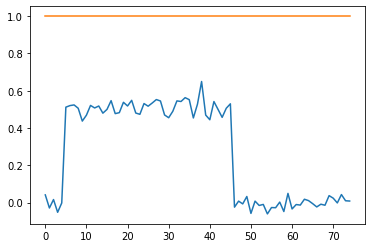

In [303]:
u, y = single_decision(16*3.2/100)
plt.plot(u)
plt.plot(y)

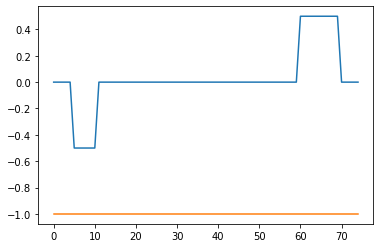

In [304]:
u, y = parametric(10, 34)
plt.plot(u)
plt.plot(y)

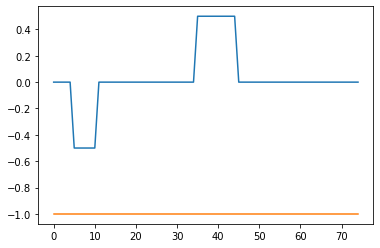

In [305]:
u, y = parametric(10, 34, pause=25)
plt.plot(u)
plt.plot(y)

# RNN Class

In [306]:
class RNN(nn.Module):

    def __init__(self, network_size=128,rank=1):

        super(RNN, self).__init__()
        self.network_size = network_size
        self.rank=rank

        # Weight initialization
        #unit rank rnn weight matrix J=mn^T/n
#         if rank==1:
        self.m = nn.Parameter(torch.Tensor(network_size, rank))
        self.n = nn.Parameter(torch.Tensor(network_size, rank))
        self.wi = torch.Tensor(network_size)
        self.w = torch.Tensor(network_size, 1)
        self.x0= torch.Tensor(network_size, 1)
#         else:
#             self.m = nn.Parameter(torch.Tensor(self.network_size,self.rank))
#             self.n = nn.Parameter(torch.Tensor(self.network_size,self.rank))
#             self.wi = torch.Tensor(self.network_size,1)
#             self.w = torch.Tensor(self.network_size,1)
#             self.x0= torch.Tensor(self.network_size,1)

                # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()

        with torch.no_grad():
            self.m.normal_(std=1)
            self.n.normal_(std=1)
            self.w.normal_(std=4)
            self.x0.zero_()
            self.wi.normal_(std=1)

    def forward(self, u, visible_activity=False):
        
        # print(u)
        if len(u.shape) == 1:
            u = u.unsqueeze(0)
            
            
            
        input_len=u.size(1)
        batch_size=u.size(0)
        
        x = torch.zeros(batch_size, self.network_size)
        z = torch.zeros(u.shape)

        r = self.activation(x)

        if visible_activity:
            unit_activity = torch.zeros(batch_size, input_len+1, self.network_size)
            unit_activity[:,0,:] = x

        for i in range(input_len):
            delta_x = (
                -x
                + r.matmul(self.n).matmul(self.m.t()) / self.network_size
                + torch.outer(u[:,i], self.wi.squeeze())
            ) * (self.dt / self.tau)

            x = x + delta_x
            r = self.activation(x)
            if visible_activity:
                unit_activity[:,i+1,:] = x

            output = torch.matmul(r, self.w) / self.network_size
            z[:, i] = output.squeeze()

        if visible_activity:
            return z, unit_activity
        else:
            return z

# Rank-One Tests

In [307]:
sd_single_data = SingleDecisionDataset(1)
train_dataloader = DataLoader(sd_single_data, batch_size=1)
model = RNN()
train(train_dataloader, model, device)

loss: 0.996888  [    1/    1]


In [308]:
sd_single_data = SingleDecisionDataset(5)
train_dataloader = DataLoader(sd_single_data, batch_size=5)
model = RNN()
train(train_dataloader, model, device)

loss: 1.001537  [    5/    5]


In [309]:
sd_dataset = SingleDecisionDataset(8000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN()
train(train_dataloader, model, device)

loss: 0.998035  [   32/ 8000]
loss: 0.473191  [ 3232/ 8000]
loss: 0.003908  [ 6432/ 8000]


torch.Size([75])
(1, 76, 128)


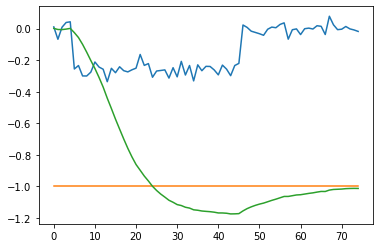

In [310]:
strength = -8
u, y = single_decision(strength*3.2/100)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)


# Full rank single_decision

In [311]:
sd_dataset = SingleDecisionDataset(8000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN(rank=128)
train(train_dataloader, model, device)

loss: 1.081836  [   32/ 8000]
loss: 0.000028  [ 3232/ 8000]
loss: 0.000014  [ 6432/ 8000]


torch.Size([75])
(1, 76, 128)


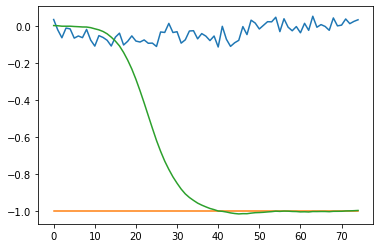

In [312]:
strength = -2

u, y = single_decision(strength*3.2/100)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

# Rank 2 Parametric

In [313]:
p_data = ParametricDataset(1)
train_dataloader = DataLoader(p_data, batch_size=1)
model = RNN(rank=2)
train(train_dataloader, model, device)


loss: 0.003243  [    1/    1]


In [314]:
p_data = ParametricDataset(5)
train_dataloader = DataLoader(p_data, batch_size=5)
model = RNN(rank=2)
train(train_dataloader, model, device)

loss: 0.134980  [    5/    5]


### Rank 2 network overfits on 1 sample parametric dataset (GOOD!)

In [315]:
p_data = ParametricDataset(1)
train_dataloader = DataLoader(p_data, batch_size=1)
model = RNN(rank=2)

for _ in range(200):
    train(train_dataloader, model, device, T=5)

loss: 0.024404  [    1/    1]
loss: 0.024300  [    1/    1]
loss: 0.024199  [    1/    1]
loss: 0.024098  [    1/    1]
loss: 0.023998  [    1/    1]
loss: 0.023890  [    1/    1]
loss: 0.023769  [    1/    1]
loss: 0.023634  [    1/    1]
loss: 0.023485  [    1/    1]
loss: 0.023323  [    1/    1]
loss: 0.023147  [    1/    1]
loss: 0.022958  [    1/    1]
loss: 0.022755  [    1/    1]
loss: 0.022540  [    1/    1]
loss: 0.022312  [    1/    1]
loss: 0.022071  [    1/    1]
loss: 0.021817  [    1/    1]
loss: 0.021552  [    1/    1]
loss: 0.021274  [    1/    1]
loss: 0.020984  [    1/    1]
loss: 0.020683  [    1/    1]
loss: 0.020370  [    1/    1]
loss: 0.020046  [    1/    1]
loss: 0.019711  [    1/    1]
loss: 0.019366  [    1/    1]
loss: 0.019010  [    1/    1]
loss: 0.018645  [    1/    1]
loss: 0.018269  [    1/    1]
loss: 0.017885  [    1/    1]
loss: 0.017492  [    1/    1]
loss: 0.017090  [    1/    1]
loss: 0.016680  [    1/    1]
loss: 0.016262  [    1/    1]
loss: 0.01

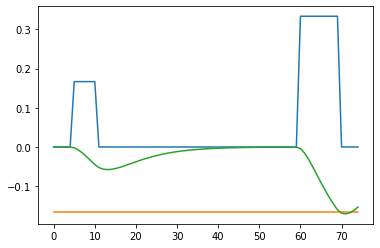

In [316]:

z=model(p_data.u).squeeze().detach().numpy()
plt.plot(p_data.u.squeeze())
plt.plot(p_data.y.squeeze())
plt.plot(z)

In [317]:
p_data = ParametricDataset(32000)
train_dataloader = DataLoader(p_data, batch_size=32)
model = RNN(rank=2)
train(train_dataloader, model, device, T=10)

loss: 0.179457  [   32/32000]
loss: 0.101851  [ 3232/32000]
loss: 0.096022  [ 6432/32000]
loss: 0.119895  [ 9632/32000]
loss: 0.124411  [12832/32000]
loss: 0.114053  [16032/32000]
loss: 0.104642  [19232/32000]
loss: 0.123390  [22432/32000]
loss: 0.103982  [25632/32000]
loss: 0.123028  [28832/32000]


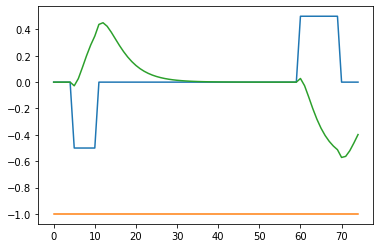

In [318]:
u, y = parametric(10, 34)
u, y = torch.Tensor(u), torch.Tensor(y)
z=model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

torch.Size([75])
(1, 76, 128)


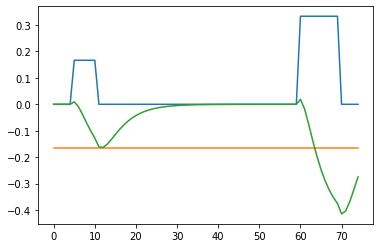

In [319]:
u, y = parametric(26, 30)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

In [320]:
pause_lengths = np.arange(25, 51, 5)
model = RNN(rank=2)

for pl in pause_lengths:
    p_data = ParametricDataset(6400, pause=pl)
    train_dataloader = DataLoader(p_data, batch_size=32)
    train(train_dataloader, model, device)
    

loss: 0.184885  [   32/ 6400]
loss: 0.122156  [ 3232/ 6400]
loss: 0.149864  [   32/ 6400]
loss: 0.172831  [ 3232/ 6400]
loss: 0.134163  [   32/ 6400]
loss: 0.102974  [ 3232/ 6400]
loss: 0.120469  [   32/ 6400]
loss: 0.026481  [ 3232/ 6400]
loss: 0.017444  [   32/ 6400]
loss: 0.011992  [ 3232/ 6400]
loss: 0.033093  [   32/ 6400]
loss: 0.027349  [ 3232/ 6400]


torch.Size([75])
(1, 76, 128)


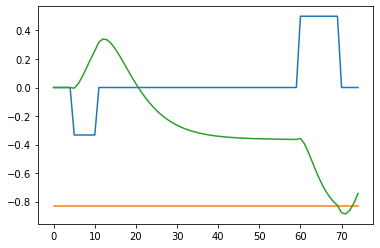

In [321]:
u, y = parametric(14, 34)
u, y = torch.Tensor(u), torch.Tensor(y)
print(u.shape)

z = model(u).squeeze().detach().numpy()
plt.plot(u.squeeze())
plt.plot(y.squeeze())
plt.plot(z)

z, u_act = model(u, visible_activity=True)
u_act = u_act.detach().numpy()
print(u_act.shape)

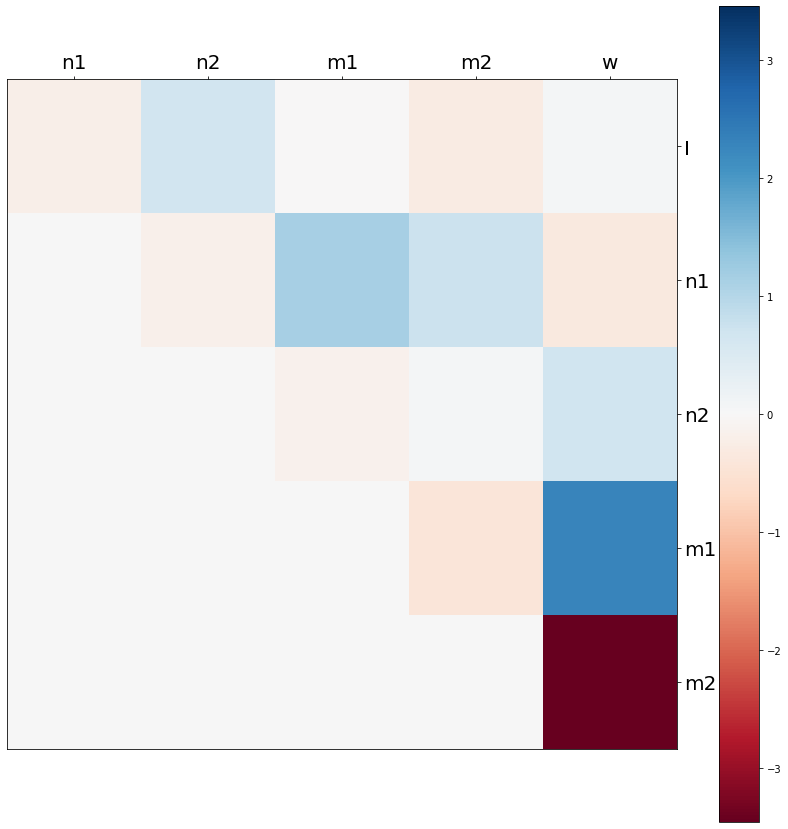

In [336]:
m=model.m.detach().numpy()
m1=m[:,0]
m2=m[:,1]


n=model.n.detach().numpy()
n1=n[:,0]
n2=n[:,1]


wi=model.wi.detach().numpy()

w=model.w.detach().numpy()
w=w.squeeze()



vector=[wi,n1,n2,m1,m2,w]
cov=np.cov(vector)
cov=np.triu(cov,k=1)
cov=cov[0:5,1:6]

# cov[cov==0]=np.Inf
bound = np.max((np.abs(np.min(cov)), np.abs(np.max(cov))))

plt.figure(figsize=(15,15))
plt.imshow(cov, cmap='RdBu', vmin=-bound, vmax=bound)
ax=plt.gca()
ax.yaxis.tick_right()
ax.xaxis.tick_top()
ax.set_aspect('equal','box')
plt.xticks(np.arange(0, 5, step=1), ['n1', 'n2', 'm1','m2','w'], fontsize=20)
plt.yticks(np.arange(0, 5, step=1), ['I','n1', 'n2', 'm1','m2'], fontsize=20)
plt.colorbar()
